<a href="https://colab.research.google.com/github/sjoon0305/KSME2026/blob/main/6. Subdomain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem description

Governing equation:
$$
u_t + uu_x =\nu u_{xx},  \quad x\in [-1, 1], \quad t>0
$$
where $\nu=0.01/\pi$

Initial condition:
$$
u(x,0)=-sin(\pi x)
$$
Boundary condition:
$$
u(-1,t)=u(1,t)=0
$$
Interfaces:
$$
x=[-0.2, 0.1, 0.5]
$$


In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
torch.set_default_dtype(torch.float64)
dtype = torch.float32

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [3]:
class Network(torch.nn.Module):
  def __init__(self):
    super(Network,self).__init__()
    self.nu = torch.tensor(0.01/np.pi)
    self.net = nn.Sequential(
      nn.Linear(2, 20), nn.Tanh(),
      nn.Linear(20, 20), nn.Tanh(),
      nn.Linear(20, 1)
    )
  def forward(self, x, y):
    data = torch.cat((x,y), dim=1)
    out = self.net(data)
    return out

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data)
        nn.init.zeros_(m.bias)

In [4]:
def fetch_interior_points(domain,batch_size):
    """
    Sampling collocation point:
    Args : 
        - domain :(numpy array) for the size of the domain
        - N_data :(int) number of points 
    out : a tensor of collocation points
    """
    dim = domain.shape[0]
    soboleng = torch.quasirandom.SobolEngine(dimension=dim,scramble=True)
    data     = soboleng.draw(batch_size,dtype=dtype)*(domain[1] - domain[0]) + domain[0]
    x       = data[:,0][:,None]
    y       = data[:,1][:,None]
    return x,y

In [5]:
def residual_loss(model,t,x):
    u = model(t,x)
    u_t, u_x = torch.autograd.grad(u.sum(), (t,x), create_graph=True)
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    loss = (u_t + u*u_x - model.nu*u_xx).pow(2).sum()/x.shape[0]
    return loss

def data_loss(model,x,y,data):
    w = model(x,y)
    loss = (w-data).pow(2).sum()/x.shape[0]
    return loss

In [6]:
# Generate Collocation Points
N_domain = 200
domain1 = np.array([[0., -1.],[1., -0.2]])
domain2 = np.array([[0., -0.2],[1., 0.5]])
domain3 = np.array([[0., 0.5],[1., 1.]])

t_dm1, x_dm1 = fetch_interior_points(domain1, N_domain)
t_dm2, x_dm2 = fetch_interior_points(domain2, N_domain)
t_dm3, x_dm3 = fetch_interior_points(domain3, N_domain)

t_dm1 = t_dm1.requires_grad_(True)
x_dm1 = x_dm1.requires_grad_(True)
t_dm2 = t_dm2.requires_grad_(True)
x_dm2 = x_dm2.requires_grad_(True)
t_dm3 = t_dm3.requires_grad_(True)
x_dm3 = x_dm3.requires_grad_(True)

C:\Users\admin\AppData\Local\Temp\ipykernel_29316\2173389795.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data     = soboleng.draw(batch_size,dtype=dtype)*(domain[1] - domain[0]) + domain[0]


In [7]:
# Generate Boundary Points
t_bc1, x_bc1 = fetch_interior_points(np.array([[0., -1.],[1., -1.]]), 100)
t_bc2, x_bc2 = fetch_interior_points(np.array([[0.,  1.],[1., 1.]]), 100)
t_init1, x_init1 = fetch_interior_points(np.array([[0., -1.],[0., -0.2]]), 25)
t_init2, x_init2 = fetch_interior_points(np.array([[0., -.2],[0., .5]]), 25)
t_init3, x_init3 = fetch_interior_points(np.array([[0., .5],[0., 1.]]), 25)
t_bc1 = t_bc1.requires_grad_(True)
x_bc1 = x_bc1.requires_grad_(True)
t_bc2 = t_bc2.requires_grad_(True)
x_bc2 = x_bc2.requires_grad_(True)

t_init1 = t_init1.requires_grad_(True)
x_init1 = x_init1.requires_grad_(True)
t_init2 = t_init2.requires_grad_(True)
x_init2 = x_init2.requires_grad_(True)
t_init3 = t_init3.requires_grad_(True)
x_init3 = x_init3.requires_grad_(True)

# Generate Interface Points
t_intf1, x_intf1 = fetch_interior_points(np.array([[0., -0.2],[1., -0.2]]), 100)
t_intf2, x_intf2 = fetch_interior_points(np.array([[0., 0.5],[1., 0.5]]), 100)
t_intf1 = t_intf1.requires_grad_(True)
x_intf1 = x_intf1.requires_grad_(True)
t_intf2 = t_intf2.requires_grad_(True)
x_intf2 = x_intf2.requires_grad_(True)

# Initial condition data
u_init_data1 = -torch.sin(torch.pi*x_init1.detach())
u_init_data2 = -torch.sin(torch.pi*x_init2.detach())
u_init_data3 = -torch.sin(torch.pi*x_init3.detach())

C:\Users\admin\AppData\Local\Temp\ipykernel_29316\2173389795.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data     = soboleng.draw(batch_size,dtype=dtype)*(domain[1] - domain[0]) + domain[0]


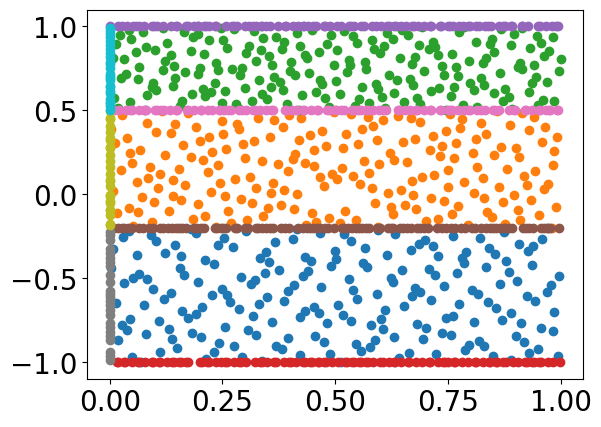

In [8]:
# Check collocation & boundary points
plt.scatter(t_dm1.detach().numpy(), x_dm1.detach().numpy())
plt.scatter(t_dm2.detach().numpy(), x_dm2.detach().numpy())
plt.scatter(t_dm3.detach().numpy(), x_dm3.detach().numpy())
plt.scatter(t_bc1.detach().numpy(), x_bc1.detach().numpy())
plt.scatter(t_bc2.detach().numpy(), x_bc2.detach().numpy())
plt.scatter(t_intf1.detach().numpy(), x_intf1.detach().numpy())
plt.scatter(t_intf2.detach().numpy(), x_intf2.detach().numpy())
plt.scatter(t_init1.detach().numpy(), x_init1.detach().numpy())
plt.scatter(t_init2.detach().numpy(), x_init2.detach().numpy())
plt.scatter(t_init3.detach().numpy(), x_init3.detach().numpy())

In [9]:
model1 = Network()
model2 = Network()
model3 = Network()
model1.apply(init_weights)
model2.apply(init_weights)
model3.apply(init_weights)

Network(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [10]:
# optimizer를 하나 써서 여러 network을 training 할 수도 있다. 
# 이 경우 
# torch.optim.Adam(chain(model1.parameters(), model2.parameters()) 이런 식으로 한다.
# 더 자세한 내용은 chain 함수를 참고할 것.
# 여기서는 optimizer를 따로 사용해서 training 해본다.

optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.001)
train_history = {'loss':[]}


In [11]:
n_epochs = 20000

for epoch in range(n_epochs):
# Residual loss
  res1_loss = residual_loss(model1, t_dm1, x_dm1)
  res2_loss = residual_loss(model2, t_dm2, x_dm2)
  res3_loss = residual_loss(model3, t_dm3, x_dm3)

# Boundary loss
  bc1_loss = data_loss(model1, t_bc1, x_bc1, 0)
  bc2_loss = data_loss(model3, t_bc2, x_bc2, 0)

# Initial loss
  init1_loss = data_loss(model1, t_init1, x_init1, u_init_data1)
  init2_loss = data_loss(model2, t_init2, x_init2, u_init_data2)
  init3_loss = data_loss(model3, t_init3, x_init3, u_init_data3)
  
# Interface loss
  u_intf1_from_model1 = model1(t_intf1, x_intf1)
  u_intf1_from_model2 = model2(t_intf1, x_intf1)
  u_intf1_mean = (u_intf1_from_model1+u_intf1_from_model2)/2
  u_intf2_from_model2 = model2(t_intf2, x_intf2)
  u_intf2_from_model3 = model3(t_intf2, x_intf2)
  u_intf2_mean = (u_intf2_from_model2+u_intf2_from_model3)/2

  intf1_dm1_loss = data_loss(model1, t_intf1, x_intf1, u_intf1_mean)
  intf1_dm2_loss = data_loss(model2, t_intf1, x_intf1, u_intf1_mean)
  intf2_dm2_loss = data_loss(model2, t_intf2, x_intf2, u_intf2_mean)
  intf2_dm3_loss = data_loss(model3, t_intf2, x_intf2, u_intf2_mean)

# Flux loss
  flux_intf1_dm1 = torch.autograd.grad(intf1_dm1_loss.sum(), x_intf1, create_graph=True)[0]
  flux_intf1_dm2 = torch.autograd.grad(intf1_dm2_loss.sum(), x_intf1, create_graph=True)[0]
  flux_intf2_dm2 = torch.autograd.grad(intf2_dm2_loss.sum(), x_intf2, create_graph=True)[0]
  flux_intf2_dm3 = torch.autograd.grad(intf2_dm3_loss.sum(), x_intf2, create_graph=True)[0]

  intf1_flux_loss = (flux_intf1_dm1 - flux_intf1_dm2).pow(2).mean()
  intf2_flux_loss = (flux_intf2_dm2 - flux_intf2_dm3).pow(2).mean()

  loss1 = res1_loss + 10*bc1_loss        + 100*intf1_dm1_loss + 10*init1_loss + 10*intf1_flux_loss
  loss2 = res2_loss + 100*intf1_dm2_loss + 100*intf2_dm2_loss + 10*init2_loss + 10*intf1_flux_loss + 10*intf2_flux_loss
  loss3 = res3_loss + 100*intf2_dm3_loss + 10*init3_loss + 10*intf2_flux_loss

  # Save history
  # if epoch%10 == 0:
  #   train_history['loss'].append(float(loss.detach().numpy()))

  optimizer1.zero_grad()
  optimizer2.zero_grad()
  optimizer3.zero_grad()
  loss1.backward(retain_graph=True)
  loss2.backward(retain_graph=True)
  loss3.backward()
  optimizer1.step()
  optimizer2.step()
  optimizer3.step()

  if epoch%1000 ==0:
    print(f'Epoch: {epoch}, Loss: {float(loss1+loss2+loss3):.2}')



Epoch: 0, Loss: 2.6e+01
Epoch: 1000, Loss: 1.2
Epoch: 2000, Loss: 0.8
Epoch: 3000, Loss: 0.71
Epoch: 4000, Loss: 0.68
Epoch: 5000, Loss: 0.65
Epoch: 6000, Loss: 0.58
Epoch: 7000, Loss: 0.54
Epoch: 8000, Loss: 0.51
Epoch: 9000, Loss: 0.46
Epoch: 10000, Loss: 0.36
Epoch: 11000, Loss: 0.2
Epoch: 12000, Loss: 0.12
Epoch: 13000, Loss: 0.08
Epoch: 14000, Loss: 0.065
Epoch: 15000, Loss: 0.052
Epoch: 16000, Loss: 0.045
Epoch: 17000, Loss: 0.04
Epoch: 18000, Loss: 0.035
Epoch: 19000, Loss: 0.027


In [12]:
t_test_domain = np.linspace(0, 1, 100)
x_test_domain1 = np.linspace(-1., -0.2, 25)
x_test_domain2 = np.linspace(-0.2, 0.5, 25)
x_test_domain3 = np.linspace(0.5, 1., 25)
T_test, X_test1 = np.meshgrid(t_test_domain, x_test_domain1)
T_test, X_test2 = np.meshgrid(t_test_domain, x_test_domain2)
T_test, X_test3 = np.meshgrid(t_test_domain, x_test_domain3)

U_test1 = model1(torch.from_numpy(T_test).flatten()[:,None], torch.from_numpy(X_test1).flatten()[:,None])
U_test2 = model2(torch.from_numpy(T_test).flatten()[:,None], torch.from_numpy(X_test2).flatten()[:,None])
U_test3 = model3(torch.from_numpy(T_test).flatten()[:,None], torch.from_numpy(X_test3).flatten()[:,None])

U_test1 = U_test1.detach().numpy().reshape(25, 100)
U_test2 = U_test2.detach().numpy().reshape(25, 100)
U_test3 = U_test3.detach().numpy().reshape(25, 100)

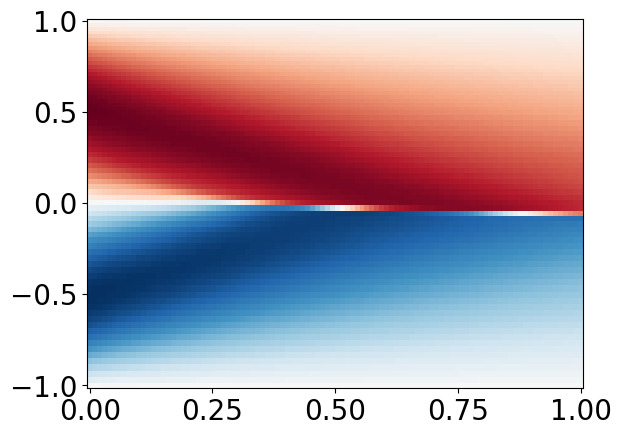

In [13]:
vmin = min(U_test1.min(), U_test2.min(), U_test3.min())
vmax = max(U_test1.max(), U_test2.max(), U_test3.max())

fig, ax = plt.subplots()

ax.pcolor(T_test, X_test1, U_test1, cmap=matplotlib.cm.RdBu, vmin=vmin, vmax=vmax)
ax.pcolor(T_test, X_test2, U_test2, cmap=matplotlib.cm.RdBu, vmin=vmin, vmax=vmax)
ax.pcolor(T_test, X_test3, U_test3, cmap=matplotlib.cm.RdBu, vmin=vmin, vmax=vmax)
# cb = fig.colorbar(p, ax=ax)

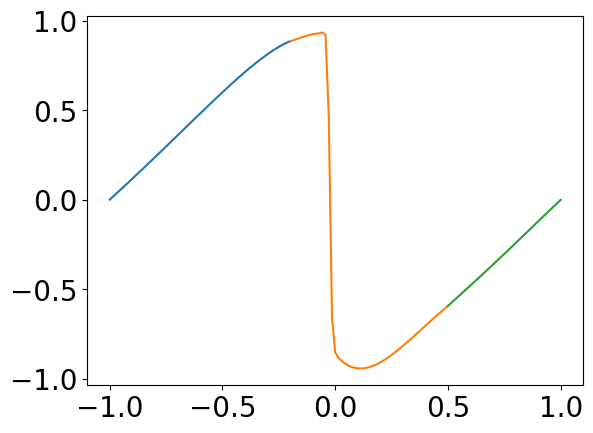

In [14]:
# Flux check
t = 0.5
t_domain = t*torch.ones(50)[:,None]
x1_at_t = torch.from_numpy(np.linspace(-1, -0.2, 50))[:,None]
x2_at_t = torch.from_numpy(np.linspace(-0.2, 0.5, 50))[:,None]
x3_at_t = torch.from_numpy(np.linspace(0.5, 1, 50))[:,None]
y1_at_t = model1(t_domain, x1_at_t)
y2_at_t = model2(t_domain, x2_at_t)
y3_at_t = model3(t_domain, x3_at_t)

plt.plot(x1_at_t, y1_at_t.detach().numpy())
plt.plot(x2_at_t, y2_at_t.detach().numpy())
plt.plot(x3_at_t, y3_at_t.detach().numpy())